In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")
from scipy.spatial.distance import hamming, euclidean, cdist
from sklearn.cluster import KMeans
import torch

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

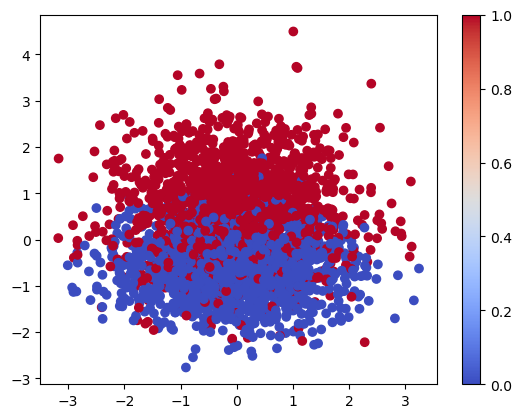

In [2]:
from sklearn.datasets import make_classification, make_blobs
X, Y = make_classification(
    n_samples=3000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, class_sep=0.7, random_state=42
)
# sep = 1.5
# X, Y = make_blobs(n_samples=1000, centers=np.array([[0,-sep],[0,sep],[sep,0],[-sep,0]]), n_features=2, random_state=42)
# Y = Y / np.max(Y)

plt.scatter(X[:,0],X[:,1],marker='o', c=Y, cmap='coolwarm')
plt.colorbar()

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.33)

In [4]:
# --- Latent ---
X_train_latent = np.hstack((X_train,Y_train.reshape(-1,1)))
X_test_latent = np.hstack((X_test,Y_test.reshape(-1,1)))

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import TensorDataset, DataLoader

# Latent Space Training
latent_dim = 2
batch_size = 1024
sigma = 1
max_epochs = 3000
early_stopping = 3
learning_rate = 1e-3
idx_cat = None
dataset_name = 'sintetic'

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')
def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)
def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + D_class
    else:
        D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
        D = D_features + D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)
def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss
class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()
        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)
    def encode(self, x):
        x = self.fc1(x)
        return x
    def forward(self, x):
        z = self.encode(x)
        return z
# Create Model
model = LinearModel(X_train_latent.shape[1], latent_dim=latent_dim)

train_dataset = TensorDataset(torch.tensor(X_train_latent).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test_latent).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
        postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []
    
    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    
    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------
    
    # set model as testing mode
    model.eval()
    batch_loss = []
    
    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())
    
    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch
    
    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_{dataset_name}.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_{dataset_name}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/{dataset_name}_latent_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

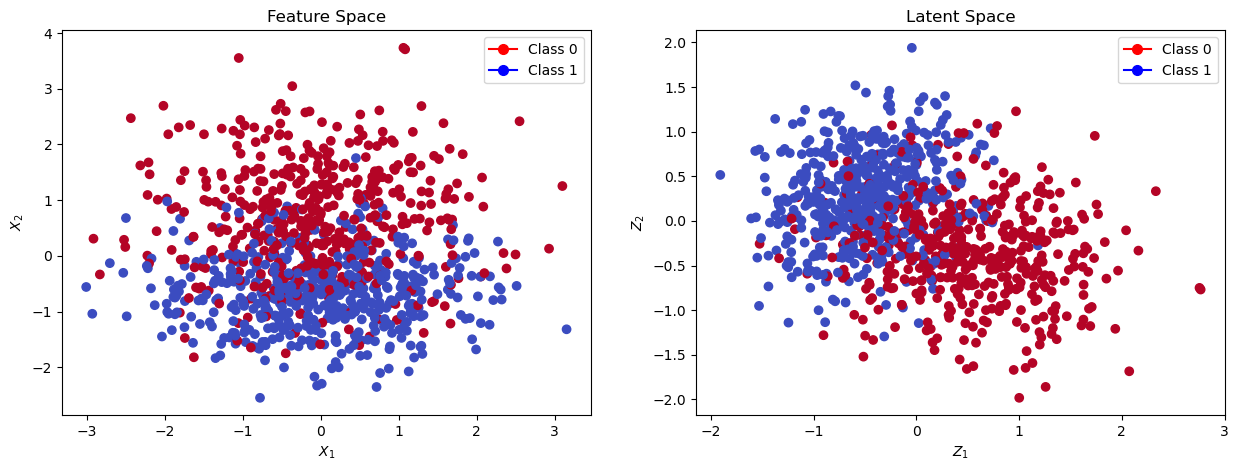

In [15]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[1].set_title('Latent Space')
pcm = ax[1].scatter(Z_test[:,0], Z_test[:,1], marker='o', c=Y_test, cmap='coolwarm')
ax[0].set_title('Feature Space')
ax[0].scatter(X_test[:,0], X_test[:,1], marker='o', c=Y_test, cmap='coolwarm')
ax[0].set_xlabel('$X_1$')
ax[0].set_ylabel('$X_2$')
ax[1].set_xlabel('$Z_1$')
ax[1].set_ylabel('$Z_2$')

legend_elements = [Line2D([0], [0], marker='o', color='r', label='Class 0',
                          markerfacecolor='r', markersize=7),
                   Line2D([0], [0], marker='o', color='b', label='Class 1',
                          markerfacecolor='b', markersize=7),
                  ]
ax[0].legend(handles=legend_elements)
ax[1].legend(handles=legend_elements)

plt.savefig("./plots/sintetic.png",bbox_inches='tight')

In [16]:
from sklearn.datasets import load_iris
data = load_iris()
X =  data.data
Y = data.target
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.10)

In [17]:
# --- Latent ---
X_train_latent = np.hstack((X_train,Y_train.reshape(-1,1)))
X_test_latent = np.hstack((X_test,Y_test.reshape(-1,1)))

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import TensorDataset, DataLoader

# Latent Space Training
latent_dim = 2
batch_size = 1024
sigma = 1
max_epochs = 3000
early_stopping = 3
learning_rate = 1e-3
idx_cat = None
dataset_name = 'iris'

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')
def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)
def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + D_class
    else:
        D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
        D = D_features + D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)
def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss
class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()
        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)
    def encode(self, x):
        x = self.fc1(x)
        return x
    def forward(self, x):
        z = self.encode(x)
        return z
# Create Model
model = LinearModel(X_train_latent.shape[1], latent_dim=latent_dim)

train_dataset = TensorDataset(torch.tensor(X_train_latent).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test_latent).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
        postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []
    
    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    
    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------
    
    # set model as testing mode
    model.eval()
    batch_loss = []
    
    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())
    
    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch
    
    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_{dataset_name}.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_{dataset_name}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/{dataset_name}_latent_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

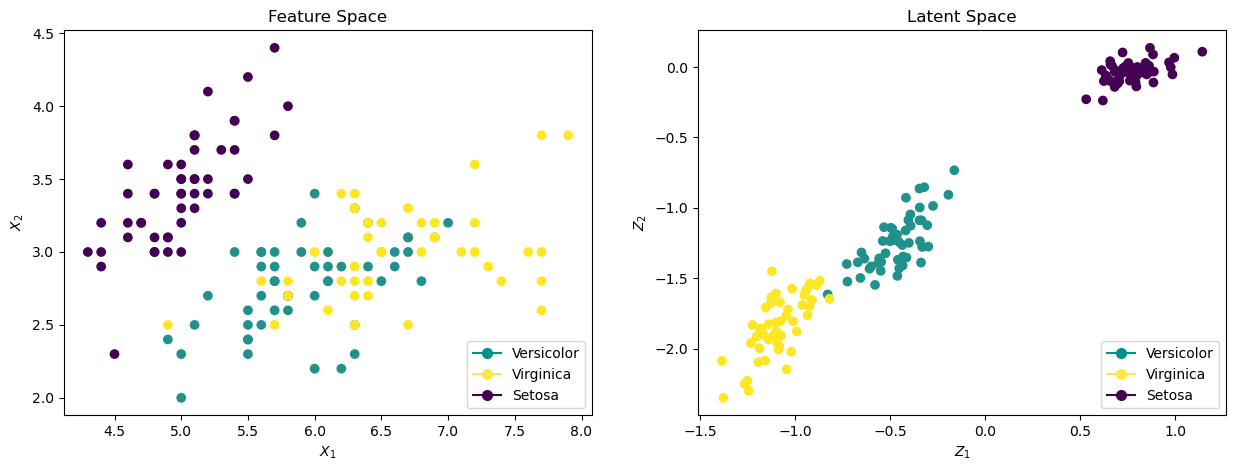

In [40]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[1].set_title('Latent Space')
pcm = ax[1].scatter(Z_test[:,0], Z_test[:,1], marker='o', c=Y_test)
ax[1].scatter(Z_train[:,0], Z_train[:,1], marker='o', c=Y_train)
ax[0].set_title('Feature Space')
ax[0].scatter(X_test[:,0], X_test[:,1], marker='o', c=Y_test)
ax[0].scatter(X_train[:,0], X_train[:,1], marker='o', c=Y_train)

legend_elements = [Line2D([0], [0], marker='o', color='#00918c', label='Versicolor',
                          markerfacecolor='#00918c', markersize=7),
                   Line2D([0], [0], marker='o', color='#ffe649', label='Virginica',
                          markerfacecolor='#ffe649', markersize=7),
                   Line2D([0], [0], marker='o', color='#480151', label='Setosa',
                          markerfacecolor='#480151', markersize=7),
                  ]
ax[0].legend(handles=legend_elements, loc='lower right')
ax[1].legend(handles=legend_elements, loc='lower right')
ax[0].set_xlabel('$X_1$')
ax[0].set_ylabel('$X_2$')
ax[1].set_xlabel('$Z_1$')
ax[1].set_ylabel('$Z_2$')

plt.savefig("./plots/iris.png", bbox_inches='tight')